### Importing Relevant Libaries 

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

models_cls = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Loading Dataset


In [7]:
df = pd.read_csv("/Users/yurumeprincess/Desktop/amazon_delivery.csv")

#To see the first 10 rows of the data set 
df.head(10)


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys
5,fxuu788413734,22,4.8,17.431668,78.408321,17.461668,78.438321,2022-03-11,21:20:00,21:30:00,Cloudy,Jam,motorcycle,Urban,130,Toys
6,njmo150975311,33,4.7,23.369746,85.339820,23.479746,85.449820,2022-03-04,19:15:00,19:30:00,Fog,Jam,scooter,Metropolitian,200,Toys
7,jvjc772545076,35,4.6,12.352058,76.606650,12.482058,76.736650,2022-03-14,17:25:00,17:30:00,Cloudy,Medium,motorcycle,Metropolitian,160,Snacks
8,uaeb808891380,22,4.8,17.433809,78.386744,17.563809,78.516744,2022-03-20,20:55:00,21:05:00,Stormy,Jam,motorcycle,Metropolitian,170,Electronics
9,bgvc052754213,36,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,21:55:00,22:10:00,Fog,Jam,motorcycle,Metropolitian,230,Toys


### Data Cleaning 

In [8]:
# Convert Order_Date to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [9]:
# Delivery_Time already exists in the dataset (in minutes)
# Create delay flag based on delivery times above median
df['Delay_Flag'] = (df['Delivery_Time'] > df['Delivery_Time'].median()).astype(int)


In [10]:
# Extract datetime-based features
df['Weekday'] = df['Order_Date'].dt.day_name()
df['Month'] = df['Order_Date'].dt.month
df['Week_Number'] = df['Order_Date'].dt.isocalendar().week

In [11]:
#Holiday indicator 
df['Holiday_Flag'] = df['Month'].isin([11, 12]).astype(int)

In [12]:
df

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,...,Traffic,Vehicle,Area,Delivery_Time,Category,Delay_Flag,Weekday,Month,Week_Number,Holiday_Flag
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,...,High,motorcycle,Urban,120,Clothing,0,Saturday,3,11,0
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,...,Jam,scooter,Metropolitian,165,Electronics,1,Friday,3,12,0
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,...,Low,motorcycle,Urban,130,Sports,1,Saturday,3,11,0
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,...,Medium,motorcycle,Metropolitian,105,Cosmetics,0,Tuesday,4,14,0
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,...,High,scooter,Metropolitian,150,Toys,1,Saturday,3,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,30,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,...,High,motorcycle,Metropolitian,160,Home,1,Thursday,3,12,0
43735,aevx342135787,21,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,...,Jam,motorcycle,Metropolitian,180,Jewelry,1,Wednesday,2,7,0
43736,xnek760674819,30,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,...,Low,scooter,Metropolitian,80,Home,0,Friday,3,10,0
43737,cynl434665991,20,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,...,High,motorcycle,Metropolitian,130,Kitchen,1,Monday,3,10,0


In [13]:
# Encode categorical variables
label_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
for col in label_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])

In [14]:
# Feature set for ML models
features = ['Agent_Age', 'Agent_Rating', 'Weekday', 'Month', 'Holiday_Flag']
df = df.dropna()

In [15]:
# Ensure numeric encoding of Weekday
if df['Weekday'].dtype == 'object':
    df['Weekday'] = LabelEncoder().fit_transform(df['Weekday'])


In [16]:
#REGRESSION: Predicting Delivery Time ---
X_reg = df[features]
y_reg = df['Delivery_Time']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)


In [17]:
X_reg

,Agent_Age,Agent_Rating,Weekday,Month,Holiday_Flag
0,37,4.9,2,3,0
1,34,4.5,0,3,0
2,23,4.4,2,3,0
3,38,4.7,5,4,0
4,32,4.6,2,3,0
...,...,...,...,...,...
43734,30,4.8,4,3,0
43735,21,4.6,6,2,0
43736,30,4.9,0,3,0
43737,20,4.7,1,3,0


In [18]:
y_reg

0        120
1        165
2        130
3        105
4        150
        ... 
43734    160
43735    180
43736     80
43737    130
43738    180
Name: Delivery_Time, Length: 43685, dtype: int64

In [19]:
reg_models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}


In [20]:
for name, model in reg_models.items():
    model.fit(X_train_r, y_train_r)
    y_pred = model.predict(X_test_r)
    print(f"\n{name}")
    print("MAE:", mean_absolute_error(y_test_r, y_pred))
    print("RMSE:", mean_squared_error(y_test_r, y_pred, squared=False))
    print("R²:", r2_score(y_test_r, y_pred))



LinearRegression
MAE: 37.13372861850136
RMSE: 48.0913965643335
R²: 0.14476406885353166

RandomForest
MAE: 36.56727294395203
RMSE: 47.90538281305626
R²: 0.15136724487769937

XGBoost
MAE: 35.05137302679861
RMSE: 46.101871826774506
R²: 0.21406201619031817


In [21]:
#CLASSIFICATION: Predicting Delay Flag ---
y_clf = df['Delay_Flag']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_reg, y_clf, test_size=0.2, random_state=42)

clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train_c, y_train_c)
y_pred_c = clf.predict(X_test_c)
y_proba_c = clf.predict_proba(X_test_c)[:, 1]


In [22]:
print("\nClassification Report (XGBoost):")
print("Accuracy:", accuracy_score(y_test_c, y_pred_c))
print("Precision:", precision_score(y_test_c, y_pred_c))
print("Recall:", recall_score(y_test_c, y_pred_c))
print("F1 Score:", f1_score(y_test_c, y_pred_c))
print("AUC:", roc_auc_score(y_test_c, y_proba_c))



Classification Report (XGBoost):
Accuracy: 0.6764335584296669
Precision: 0.6699604743083004
Recall: 0.5886876705532126
F1 Score: 0.6267001188432589
AUC: 0.7405434856066083


### Visualisations

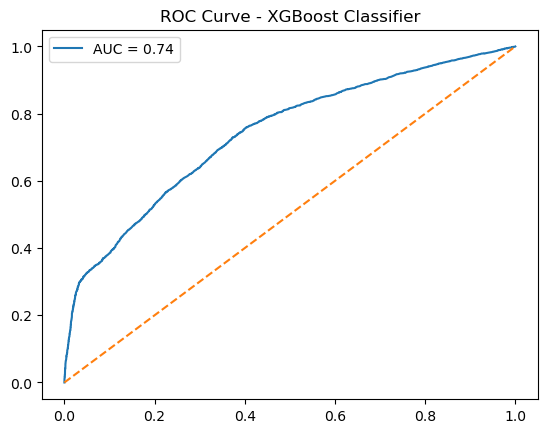

In [23]:
fpr, tpr, _ = roc_curve(y_test_c, y_proba_c)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - XGBoost Classifier")
plt.legend()
plt.show()

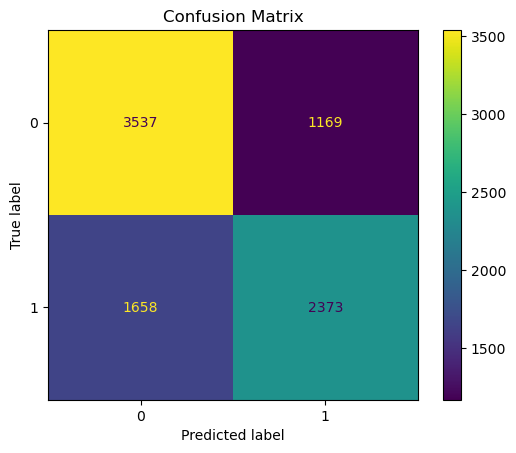

In [24]:
ConfusionMatrixDisplay(confusion_matrix(y_test_c, y_pred_c)).plot()
plt.title("Confusion Matrix")
plt.show()

### TIME SERIES FORECASTING: Prophet and SARIMA

In [25]:

df_ts = df.groupby(pd.Grouper(key='Order_Date', freq='W'))['Delivery_Time'].mean().reset_index()
df_ts.rename(columns={'Order_Date': 'ds', 'Delivery_Time': 'y'}, inplace=True)


18:19:08 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing


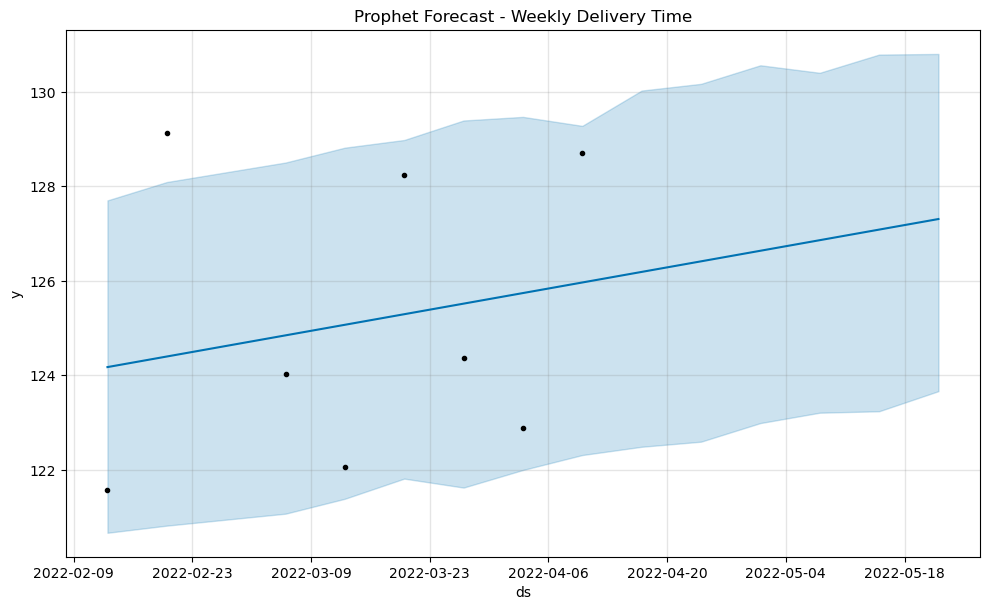

In [26]:
# Prophet Forecast
prophet_model = Prophet()
prophet_model.fit(df_ts)
future = prophet_model.make_future_dataframe(periods=6, freq='W')
forecast = prophet_model.predict(future)
prophet_model.plot(forecast)
plt.title("Prophet Forecast - Weekly Delivery Time")
plt.show()

In [27]:
# SARIMA Forecast 
if len(df_ts) >= 24:
    sarima_model = SARIMAX(df_ts.set_index('ds')['y'], order=(1,1,1), seasonal_order=(1,1,1,4))
    sarima_result = sarima_model.fit(disp=False)
    sarima_result.plot_diagnostics(figsize=(10, 6))
    plt.show()

In [29]:
df_weekly = df.groupby(pd.Grouper(key='Order_Date', freq='W'))['Delivery_Time'].mean().reset_index()
real_mean = df_weekly['Delivery_Time'].mean()
real_std = df_weekly['Delivery_Time'].std()

In [30]:
#To Simulate 104 weeks (2 years)
weeks = pd.date_range(start='2022-01-01', periods=104, freq='W')


In [32]:
# To create pattern using real mean, std, and sinusoidal seasonality
np.random.seed(42)
trend = np.linspace(real_mean - 5, real_mean + 5, 104)
seasonality = 4 * np.sin(2 * np.pi * np.arange(104) / 52)  # annual pattern
noise = np.random.normal(0, real_std, 104)
simulated = trend + seasonality + noise
df_dummy = pd.DataFrame({'ds': weeks, 'y': simulated})


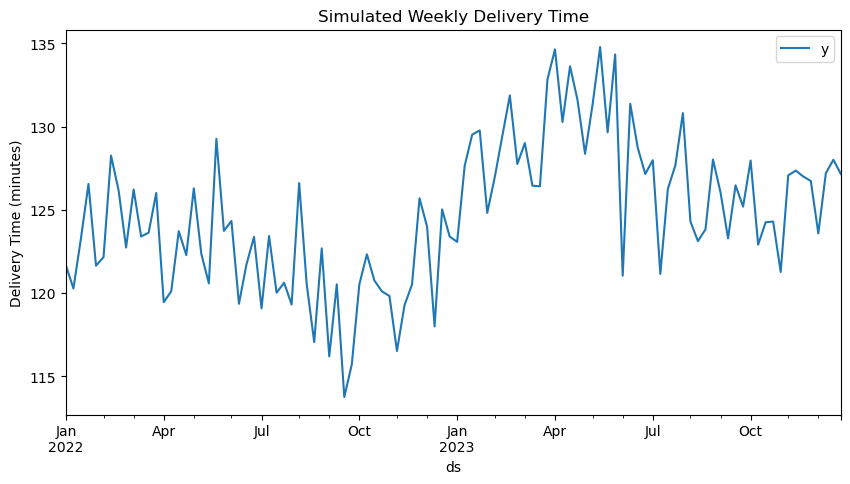

In [33]:
#To Visualise the Dummy Dataset
df_dummy.set_index('ds').plot(figsize=(10,5), title='Simulated Weekly Delivery Time')
plt.ylabel('Delivery Time (minutes)')
plt.show()


In [ ]:
# To Add Random Holiday Peaks

In [34]:

holiday_weeks = ['2022-12-25', '2023-01-01', '2023-11-24']
df_dummy.loc[df_dummy['ds'].isin(pd.to_datetime(holiday_weeks)), 'y'] += 8


# HYBRID: SARIMA Residuals + XGBoost

In [35]:
if 'sarima_result' in locals():
    residuals = sarima_result.resid.dropna().reset_index()
    residuals['time_idx'] = np.arange(len(residuals))
    X_hybrid = residuals[['time_idx']]
    y_hybrid = residuals['resid']

    hybrid_model = XGBRegressor(random_state=42)
    hybrid_model.fit(X_hybrid, y_hybrid)

    future_idx = pd.DataFrame({'time_idx': np.arange(len(residuals), len(residuals)+6)})
    future_residuals = hybrid_model.predict(future_idx)

    print("Hybrid Model: Future Residual Forecasts", future_residuals)

## additional 


## REGRESSION MODEL COMPARISON 

In [36]:
reg_results = []

for name, model in reg_models.items():
    y_pred = model.predict(X_test_r)
    reg_results.append({
        'Model': name,
        'MAE': mean_absolute_error(y_test_r, y_pred),
        'RMSE': mean_squared_error(y_test_r, y_pred, squared=False),
        'R²': r2_score(y_test_r, y_pred)
    })


In [37]:
# Convert to DataFrame for display
reg_comparison = pd.DataFrame(reg_results).sort_values(by='RMSE')
print("\n📊 Regression Model Comparison:")
print(reg_comparison)


📊 Regression Model Comparison:
              Model        MAE       RMSE        R²
2           XGBoost  35.051373  46.101872  0.214062
1      RandomForest  36.567273  47.905383  0.151367
0  LinearRegression  37.133729  48.091397  0.144764


## CLASSIFICATION MODEL COMPARISON 

In [38]:
cls_results = []

for name, model in models_cls.items():
    model.fit(X_train_c, y_train_c)
    y_pred = model.predict(X_test_c)
    y_proba = model.predict_proba(X_test_c)[:, 1]

    cls_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test_c, y_pred),
        'Precision': precision_score(y_test_c, y_pred),
        'Recall': recall_score(y_test_c, y_pred),
        'F1 Score': f1_score(y_test_c, y_pred),
        'AUC': roc_auc_score(y_test_c, y_proba)
    })


In [39]:
cls_comparison = pd.DataFrame(cls_results).sort_values(by='F1 Score', ascending=False)
print("\n📊 Classification Model Comparison:")
print(cls_comparison)


📊 Classification Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC
2              XGBoost  0.676434   0.669960  0.588688  0.626700  0.740543
1        Random Forest  0.659723   0.649014  0.571570  0.607835  0.708613
0  Logistic Regression  0.660639   0.652547  0.565616  0.605980  0.706704


In [40]:
### Plot Comparison 

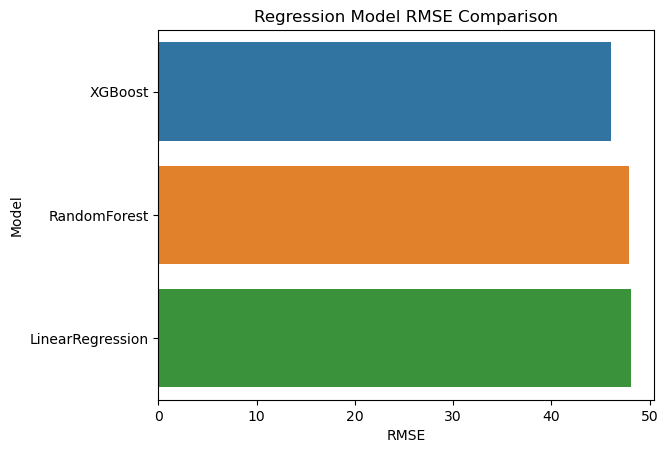

In [41]:
# Bar plot for regression RMSE
sns.barplot(x='RMSE', y='Model', data=reg_comparison)
plt.title('Regression Model RMSE Comparison')
plt.show()


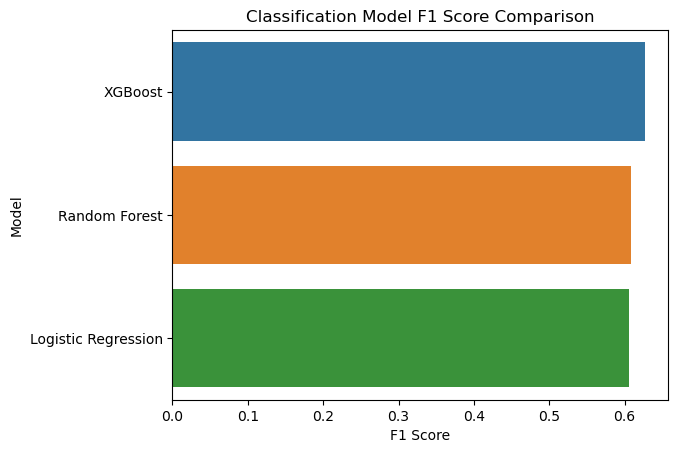

In [42]:
# Bar plot for classification F1 Score
sns.barplot(x='F1 Score', y='Model', data=cls_comparison)
plt.title('Classification Model F1 Score Comparison')
plt.show()